In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/GDG ML Assignment/train.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = np.array(data)
m, n = data.shape
np.random.shuffle(data)

data_dev = data[0:1000].T
Y_dev = data_dev[0]
X_dev = data_dev[1:n]
X_dev = X_dev / 255.

data_train = data[1000:m].T
Y_train = data_train[0]
X_train = data_train[1:n]
X_train = X_train / 255.
_, m_train = X_train.shape



---



In [ ]:
def params():
    w1 = np.random.rand(10, 784) - 0.5
    b1 = np.random.rand(10, 1) - 0.5

    w2 = np.random.rand(10, 10) - 0.5
    b2 = np.random.rand(10, 1) - 0.5

    w3 = np.random.rand(10, 10) - 0.5
    b3 = np.random.rand(10, 1) - 0.5

    return w1, b1, w2, b2, w3, b3

def ada_act(z, k0, k1):
    return k0 + k1*z

def softmax(z):
    a = np.exp(z) / sum(np.exp(z))
    return a

def forward_propagation(w1, b1, w2, b2, w3, b3, X, k0, k1):
    z1 = w1.dot(X) + b1
    a1 = ada_act(z1, k0, k1)

    z2 = w2.dot(a1) + b2
    a2 = ada_act(z2, k0, k1)

    z3 = w3.dot(a2) + b3
    a3 = softmax(z3)

    return z1, a1, z2, a2, z3, a3

def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

def back_propagation(X, Y, z1, a1, z2, a2, z3, a3, w1, b1, w2, b2, w3, b3, k0, k1):
    t = X.shape[1]
    one_hot_Y = one_hot(Y)

    dz3 = a3 - one_hot_Y
    dw3 = (1 / t) * dz3.dot(a2.T)
    db3 = np.mean(dz3, axis=1, keepdims=True)

    da2 = w3.T.dot(dz3)
    dz2 = k1 * da2
    dw2 = (1 / t) * dz2.dot(a1.T)
    db2 = np.mean(dz2, axis=1, keepdims=True)

    dK2 = np.mean(da2 * z2, axis=1)

    da1 = w2.T.dot(dz2)
    dz1 = k1 * da1
    dw1 = (1 / t) * dz1.dot(X.T)
    db1 = np.mean(dz1, axis=1, keepdims=True)

    dK1 = np.mean(da1 * z1, axis=1)

    dK = dK2 + dK1

    return dw1, db1, dw2, db2, dw3, db3, dK

def update_params(w1, b1, w2, b2, w3, b3, dW1, db1, dW2, db2, dW3, db3, dK, k0, k1, alpha):
    w1 -= alpha * dW1
    b1 -= alpha * db1
    w2 -= alpha * dW2
    b2 -= alpha * db2
    w3 -= alpha * dW3
    b3 -= alpha * db3

    k0 -= alpha * np.mean(dK)
    k1 -= alpha * np.mean(dK)

    return w1, b1, w2, b2, w3, b3, k0, k1

In [ ]:
def get_predictions(a3):
    return np.argmax(a3, axis = 0)

def get_accuracy(predictions, Y):
    return np.sum(predictions == Y) / Y.size

def cross_entropy_loss(y_pred, y_true):
    y_pred = np.clip(y_pred, 1e-10, 1 - 1e-10)
    t = y_true.shape[0]
    return -np.sum(y_true * np.log(y_pred)) / t

def gradient_descent(X_train, Y_train, X_dev, Y_dev, iterations, alpha):
    w1, b1, w2, b2, w3, b3 = params()
    k0 = 0
    k1 = 1

    train_losses = []
    dev_losses = []
    train_accuracies = []
    dev_accuracies = []

    for i in range(iterations):
        z1, a1, z2, a2, z3, a3 = forward_propagation(w1, b1, w2, b2, w3, b3, X_train, k0, k1)
        loss_train = cross_entropy_loss(a3, one_hot(Y_train))
        predictions_train = get_predictions(a3)
        accuracy_train = get_accuracy(predictions_train, Y_train)

        _, _, _, _, _, a3_dev = forward_propagation(w1, b1, w2, b2, w3, b3, X_dev, k0, k1)
        loss_dev = cross_entropy_loss(a3_dev, one_hot(Y_dev))
        predictions_dev = get_predictions(a3_dev)
        accuracy_dev = get_accuracy(predictions_dev, Y_dev)

        train_losses.append(loss_train)
        train_accuracies.append(accuracy_train)
        dev_losses.append(loss_dev)
        dev_accuracies.append(accuracy_dev)

        dW1, db1, dW2, db2, dW3, db3, dK = back_propagation(X_train, Y_train, z1, a1, z2, a2, z3, a3, w1, b1, w2, b2, w3, b3, k0, k1)
        w1, b1, w2, b2, w3, b3, k0, k1 = update_params(w1, b1, w2, b2, w3, b3, dW1, db1, dW2, db2, dW3, db3, dK, k0, k1, alpha)

        if i % 10 == 0:
            print(f"Iteration {i}: \nTrain Loss = {loss_train:.3f}, Dev Loss = {loss_dev:.3f}, \nTrain Accuracy = {accuracy_train:.3f}, Dev Accuracy = {accuracy_dev:.3f}")

    return w1, b1, w2, b2, w3, b3, k0, k1, train_losses, dev_losses, train_accuracies, dev_accuracies

In [ ]:
w1, b1, w2, b2, w3, b3, k0, k1, train_losses, dev_losses, train_accuracies, dev_accuracies = gradient_descent(X_train, Y_train, X_dev, Y_dev, 500, 0.1)

Iteration 0: 
Train Loss = 18464.246, Dev Loss = 443.118, 
Train Accuracy = 0.137, Dev Accuracy = 0.140
Iteration 10: 
Train Loss = 8331.133, Dev Loss = 199.274, 
Train Accuracy = 0.325, Dev Accuracy = 0.345
Iteration 20: 
Train Loss = 6903.197, Dev Loss = 165.815, 
Train Accuracy = 0.477, Dev Accuracy = 0.500
Iteration 30: 
Train Loss = 5794.370, Dev Loss = 139.054, 
Train Accuracy = 0.559, Dev Accuracy = 0.570
Iteration 40: 
Train Loss = 4984.742, Dev Loss = 119.313, 
Train Accuracy = 0.613, Dev Accuracy = 0.618
Iteration 50: 
Train Loss = 4425.527, Dev Loss = 105.833, 
Train Accuracy = 0.654, Dev Accuracy = 0.666
Iteration 60: 
Train Loss = 4026.225, Dev Loss = 96.397, 
Train Accuracy = 0.683, Dev Accuracy = 0.690
Iteration 70: 
Train Loss = 3726.858, Dev Loss = 89.456, 
Train Accuracy = 0.708, Dev Accuracy = 0.716
Iteration 80: 
Train Loss = 3494.775, Dev Loss = 84.162, 
Train Accuracy = 0.728, Dev Accuracy = 0.730
Iteration 90: 
Train Loss = 3310.641, Dev Loss = 80.018, 
Train Acc

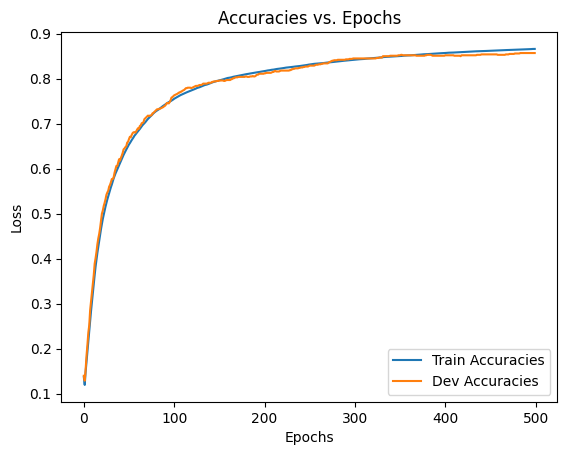

In [ ]:
plt.plot(train_accuracies, label='Train Accuracies')
plt.plot(dev_accuracies, label='Dev Accuracies')
plt.title('Accuracies vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

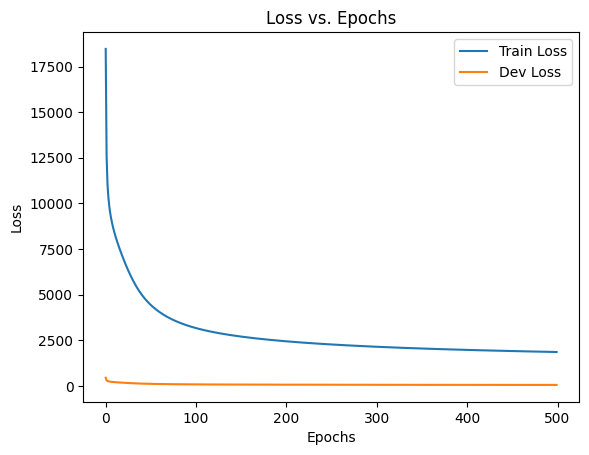

In [ ]:
plt.plot(train_losses, label='Train Loss')
plt.plot(dev_losses, label='Dev Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
final_predictions = get_predictions(forward_propagation(w1, b1, w2, b2, w3, b3, X_dev, k0, k1)[-1])
f1 = f1_score(Y_dev, final_predictions, average='macro')
print(f"Final F1-Score: {f1}")

Final F1-Score: 0.8534946537857548
